In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

In [2]:
def aggregate_beds(sample_directory, sample_name_list, sample_suffix, base_bed, bed_col_names=["chr","start","end"]):
    base_df = pd.read_csv(base_bed, sep='\t', names = bed_col_names, usecols = range(0,len(bed_col_names)))
    sample_list = [base_df] #Make a list, start with just the bed file. 
    
    for filename in sample_name_list:
        full_name = sample_directory + filename + sample_suffix
        print("Reading: "+full_name)
        #Read the file and take the last two columns
        try:
            data = pd.read_csv(full_name, usecols = ["N_methy_ori","N_total_ori"], sep = '\t')
            #Make the column names unique
            col_key = filename.split("_")[0]
            data.rename(columns = {"N_methy_ori":col_key+"_methyl_counts","N_total_ori":col_key+"_total_counts"}, inplace = True)
            data[col_key+"_methyl_pct"]=data[col_key+"_methyl_counts"]/data[col_key+"_total_counts"]*100
            #append to the sample list
            sample_list.append(data)
        except Exception as e:
            print(e)
            
    samples = pd.concat(sample_list, axis = 1)
    return samples

def aggregate_samples(data_df, sample_metadata, cell_type_list = ["hiPSC_primed", "hiPSC_naive", "hPGCLC", "oogonia_old", "oogonia_new_D3", "oogonia_new_D5", "oogonia_naive", "hPGC_wk5.5_F", "hPGC_wk7_F", "hPGC_wk9_F", "hPGC_wk9_M"]):
    methyl_pct_list = []
    for type in cell_type_list:
        sample_groups = sample_metadata[sample_metadata["sample_key"]==type]["id"]
        methyl_counts_cols = [x + "methyl_counts" for x in sample_groups] #get all columns with methyl counts
        total_counts_cols = [x + "total_counts" for x in sample_groups] #get all columns with total counts
        methyl_pct = data_df[methyl_counts_cols].sum(axis=1) / data_df[total_counts_cols].sum(axis=1) * 100
        methyl_pct_list.append(methyl_pct)
        
    methyl_pct_aggregated = pd.concat([data_df[["chr","start","end","gene"]]] + methyl_pct_list, axis = 1)
    methyl_pct_aggregated.columns = ["chr","start","end","gene"] + cell_type_list
    methyl_pct_aggregated.dropna(inplace=True)
    return methyl_pct_aggregated

def methyl_percent_plot(key_x, key_y, xlabel, ylabel, title, methyl_pct_aggregated):

    values = np.vstack([methyl_pct_aggregated[key_x], methyl_pct_aggregated[key_y]])
    kernel = stats.gaussian_kde(values)(values)
    
    sns.scatterplot(x=methyl_pct_aggregated[key_x],y=methyl_pct_aggregated[key_y], c = kernel, cmap = 'viridis', alpha = 0.8,s = 5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim([0,100])
    plt.ylim([0,100])
    plt.title(title)
    plt.savefig(str(title + "_" + ylabel + " vs " + xlabel + ".png").replace(" ", "_"), dpi = 256)

def methyl_percent_jointplot(key_x, key_y, xlabel, ylabel, title, methyl_pct_aggregated, filename):
    g = sns.jointplot(data=methyl_pct_aggregated, x=key_x, y=key_y, joint_kws={'color':'#00AFD7'}, marginal_kws={'color':'#00AFD7', 'fill':True}, kind = "kde")
    g.plot_joint(sns.scatterplot, zorder=0, s=3, color='black', alpha=0.6)#size= 3, alpha=0.8, color = "black")

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim([0,100])
    plt.ylim([0,100])
    plt.suptitle(title)
    plt.savefig(filename, dpi = 256)

In [3]:
sample_data = pd.read_csv("data/EMseq_samples_noGuo.csv")

In [4]:
sample_data

,id,base_name,Cell_type,TFs,Cell_line,Sex,sample_key,Study
0,01_,01_A4_1_val_1_bismark_bt2_pe.deduplicated.bismark,hPGCLC,NaN,A4,M,hPGCLC,Smela2024
1,02_,02_D3_1_val_1_bismark_bt2_pe.deduplicated.bismark,oogonia_old,D3,F3,F,oogonia_old,Smela2024
2,03_,03_DNR3_1_val_1_bismark_bt2_pe.deduplicated.bi...,oogonia_old,D3,F3,F,oogonia_old,Smela2024
3,04_,04_F2_1_val_1_bismark_bt2_pe.deduplicated.bismark,hPGCLC,NaN,F2,F,hPGCLC,Smela2024
4,05_,05_F3_1_val_1_bismark_bt2_pe.deduplicated.bismark,hiPSC_primed,NaN,F3,F,hiPSC_primed,Smela2024
...,...,...,...,...,...,...,...,...
59,60_,DRR142997_trimmed_bismark_bt2.deduplicated.bis...,aggregate cultured PGCLC,NaN,ag120_1390G3_VT,F,xrOvary_day120_DDX4+,Yamashiro2018
60,61_,DRR142998_trimmed_bismark_bt2.deduplicated.bis...,aggregate cultured PGCLC,NaN,ag120_1390G3_VT,F,xrOvary_day120_DDX4+,Yamashiro2018
61,62_,DRR142999_trimmed_bismark_bt2.deduplicated.bis...,aggregate cultured PGCLC,NaN,ag120_1390G3_VT,F,xrOvary_day120_DDX4+,Yamashiro2018
62,63_,DRR143000_trimmed_bismark_bt2.deduplicated.bis...,aggregate cultured PGCLC,NaN,ag120_1390G3_VT,F,xrOvary_day120_DDX4+,Yamashiro2018


In [5]:
#Load the chromosome data
chroms_df = aggregate_beds(base_bed="base_beds/hg38+controls.chrom.bed", sample_directory="data/chrom/", sample_name_list = sample_data["base_name"], sample_suffix=".chrom")
chroms_df

Reading: data/chrom/01_A4_1_val_1_bismark_bt2_pe.deduplicated.bismark.chrom
Reading: data/chrom/02_D3_1_val_1_bismark_bt2_pe.deduplicated.bismark.chrom
Reading: data/chrom/03_DNR3_1_val_1_bismark_bt2_pe.deduplicated.bismark.chrom
Reading: data/chrom/04_F2_1_val_1_bismark_bt2_pe.deduplicated.bismark.chrom
Reading: data/chrom/05_F3_1_val_1_bismark_bt2_pe.deduplicated.bismark.chrom
Reading: data/chrom/06_PGP1_1_val_1_bismark_bt2_pe.deduplicated.bismark.chrom
Reading: data/chrom/07_F2_D4TDZG_1_val_1_bismark_bt2_pe.deduplicated.bismark.chrom
Reading: data/chrom/08_F3_D4TGS3_1_val_1_bismark_bt2_pe.deduplicated.bismark.chrom
Reading: data/chrom/09_PGP1_D4TR8G_1_val_1_bismark_bt2_pe.deduplicated.bismark.chrom
Reading: data/chrom/10_F2_D4TDZG_1_val_1_bismark_bt2_pe.deduplicated.bismark.chrom
Reading: data/chrom/11_F3_D4TGS3_1_val_1_bismark_bt2_pe.deduplicated.bismark.chrom
Reading: data/chrom/12_PGP1_D4TR8G_1_val_1_bismark_bt2_pe.deduplicated.bismark.chrom
Reading: data/chrom/13_F2_D4TDZG_naive

,chr,start,end,01_methyl_counts,01_total_counts,01_methyl_pct,02_methyl_counts,02_total_counts,02_methyl_pct,03_methyl_counts,...,DRR142998_methyl_pct,DRR142999_methyl_counts,DRR142999_total_counts,DRR142999_methyl_pct,DRR143000_methyl_counts,DRR143000_total_counts,DRR143000_methyl_pct,DRR143001_methyl_counts,DRR143001_total_counts,DRR143001_methyl_pct
0,chr1,0,248956422,11818125.0,18685092.0,63.248953,4370374.0,5359787.0,81.540069,13192026.0,...,13.779395,867583.0,6229691.0,13.926582,863936.0,6241826.0,13.841078,877130.0,6278160.0,13.971132
1,chr2,0,242193529,9886384.0,16014933.0,61.732284,3767084.0,4539576.0,82.983168,11353579.0,...,14.684397,874518.0,5894682.0,14.835711,872234.0,5909025.0,14.761048,885486.0,5946234.0,14.891543
2,chr3,0,198295559,7391028.0,12134160.0,60.910916,2871935.0,3449730.0,83.251008,8613937.0,...,15.199984,690757.0,4493964.0,15.370773,685769.0,4494552.0,15.257783,695770.0,4529669.0,15.360283
3,chr4,0,190214555,6354350.0,10778528.0,58.953783,2571851.0,3079088.0,83.526388,7603548.0,...,16.601669,656919.0,3908735.0,16.806435,651193.0,3914645.0,16.634791,663394.0,3941389.0,16.831477
4,chr5,0,181538259,6675379.0,11003642.0,60.665178,2611515.0,3148641.0,82.941021,7772057.0,...,15.535219,638716.0,4069759.0,15.694197,634409.0,4074802.0,15.569076,646191.0,4103958.0,15.745556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,chrEBV,0,171823,170.0,404.0,42.079208,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,10.0,0.000000,0.0,4.0,0.000000
195,phage_lambda,0,48502,9053.0,1747945.0,0.517922,15340.0,3863888.0,0.397009,76315.0,...,0.506076,1158.0,223127.0,0.518987,1160.0,222558.0,0.521212,1181.0,223984.0,0.527270
196,plasmid_puc19c,0,2686,222893.0,224858.0,99.126115,392194.0,395091.0,99.266751,1360693.0,...,100.000000,311.0,311.0,100.000000,265.0,265.0,100.000000,325.0,325.0,100.000000
197,phage_T4,0,168903,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
chroms_df.to_csv("output/chromosomes/2024-01-18_chromosome_methylation_averages.csv")

In [7]:
#make chromosome plots

#get the percentage columns
pct_cols = [col for col in chroms_df.columns if 'pct' in col]

chr_list = ["chr1","chr2","chr3","chr4","chr5","chr6","chr7","chr8","chr9","chr10","chr11","chr12","chr13","chr14","chr15","chr16","chr17","chr18","chr19","chr20","chr21","chr22","chrX","chrY","chrM","phage_lambda","plasmid_puc19c"]


chroms_to_plot = chroms_df[["chr"] + pct_cols].set_index("chr").loc[chr_list]


#chroms_to_plot.to_csv("output/chromosomes/2024-01-18_chromosome_methylation_averages_for_plotting.csv")

#NOTE: need to manually get rid of cells that should be blank (for example, chrY in females)

In [29]:
chroms_to_plot2 = pd.read_csv("output/chromosomes/2024-01-18_chromosome_methylation_averages_for_plotting.csv", index_col=0)
chroms_to_plot2

,hiPSC_primed 1,hiPSC_primed 2,hiPSC_reset 1,hiPSC_reset 2,hiPSC_reset 3,hPGCLC 1,hPGCLC 2,iOLC_D3_-DNMT1 1,iOLC_D3_-DNMT1 2,iOLC_D3 1,...,xrOvary_d120_TFAP2C+ 5,xrOvary_d120_TFAP2C+ 6,xrOvary_d120_TFAP2C+ 7,xrOvary_d120_TFAP2C+ 8,xrOvary_d120_DDX4+TFAP2C+ 1,xrOvary_d120_DDX4+TFAP2C+ 2,xrOvary_d120_DDX4+TFAP2C+ 3,xrOvary_d120_DDX4+TFAP2C+ 4,xrOvary_d120_DDX4+TFAP2C+ 5,xrOvary_d120_DDX4+TFAP2C+ 6
chr,,,,,,,,,,,,,,,,,,,,,
1,81.924158,80.144878,72.160863,67.635136,78.505538,63.248953,60.850249,81.540069,80.788351,24.055632,...,20.185957,20.282881,20.095464,20.188980,13.088483,12.960046,12.279838,12.701179,13.064315,13.033654
2,83.464224,80.969833,73.882172,69.274653,79.591324,61.732284,59.524051,82.983168,82.372663,25.601458,...,21.686510,21.703338,21.477484,21.589242,14.397006,14.212530,13.668832,14.073708,14.287425,14.282363
3,83.671610,81.058049,73.997016,69.420633,79.286928,60.910916,58.981619,83.251008,82.798930,24.780712,...,22.560877,22.552985,22.369672,22.497442,15.191353,14.970439,14.515579,14.899709,15.108005,15.088065
4,84.207099,81.845939,74.240581,69.581711,80.027757,58.953783,57.573999,83.526388,83.046389,25.324781,...,23.387430,23.378260,23.125900,23.267013,16.091884,15.879280,15.487972,15.780309,15.963403,15.994503
5,83.521559,81.013061,73.561306,69.225565,79.562446,60.665178,58.506906,82.941021,82.438833,25.033632,...,22.663085,22.748881,22.515855,22.603858,15.110189,14.860500,14.480122,14.815397,15.089789,15.021344
6,82.356341,80.050329,73.014365,68.498968,78.489518,59.652030,57.646283,82.025198,81.488756,25.503639,...,22.319895,22.394392,22.173998,22.264203,15.298342,15.103966,14.516520,14.943122,15.191660,15.174125
7,83.068073,80.794539,73.326205,68.778659,79.109168,61.619510,59.895446,82.838305,82.009200,25.661294,...,22.422000,22.423017,22.264210,22.363270,14.957098,14.787474,14.075220,14.623053,14.915497,14.900806
8,83.369969,80.926460,73.415037,68.733182,79.311106,60.707397,58.592794,82.689502,82.064371,24.655118,...,21.930386,21.962960,21.739735,21.844860,15.036813,14.894152,14.264171,14.696205,15.005869,14.966725
9,82.387837,79.988554,73.217993,68.814102,78.950517,62.194499,59.864180,82.223661,81.426537,25.793175,...,20.103901,20.150534,19.941937,20.018650,13.269759,13.117577,12.446168,12.884244,13.168416,13.132771


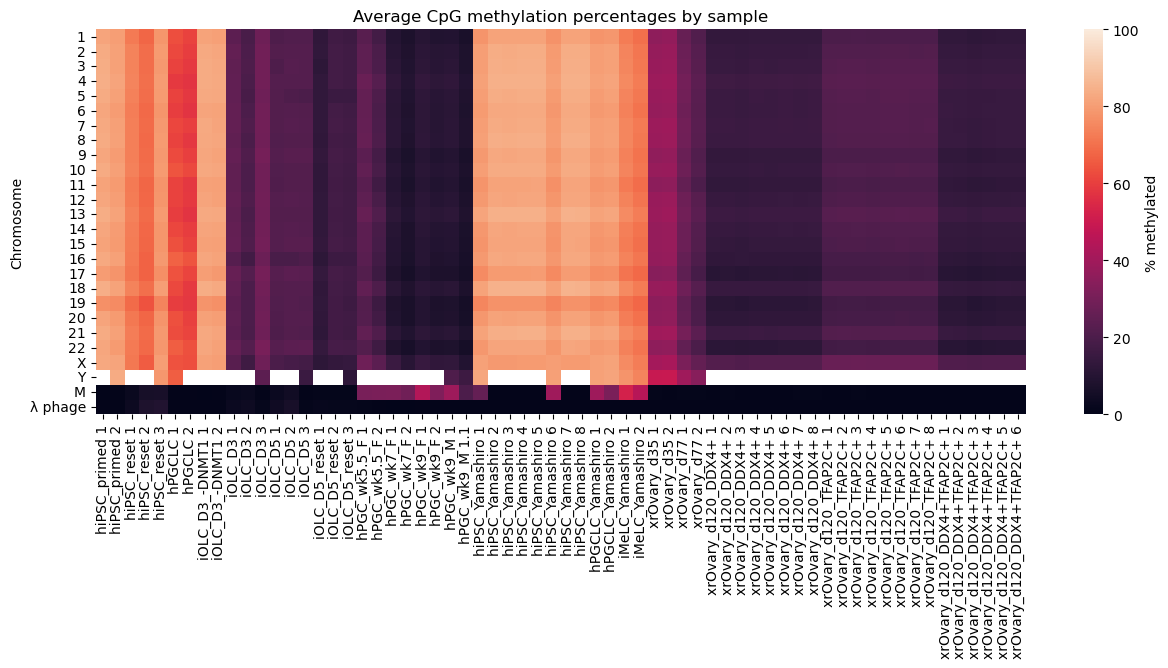

In [30]:
fig, ax = plt.subplots(figsize=(15,5))
sns.heatmap(chroms_to_plot2, vmin = 0, vmax = 100, xticklabels=True, yticklabels=True, cbar_kws={'label': '% methylated'}, ax=ax)
plt.title("Average CpG methylation percentages by sample")
plt.ylabel("Chromosome")
plt.savefig("output/chromosomes/2024-01-18_chromosome_methylation.png", dpi=256, bbox_inches = "tight")
plt.savefig("output/chromosomes/2024-01-18_chromosome_methylation.svg", bbox_inches = "tight")

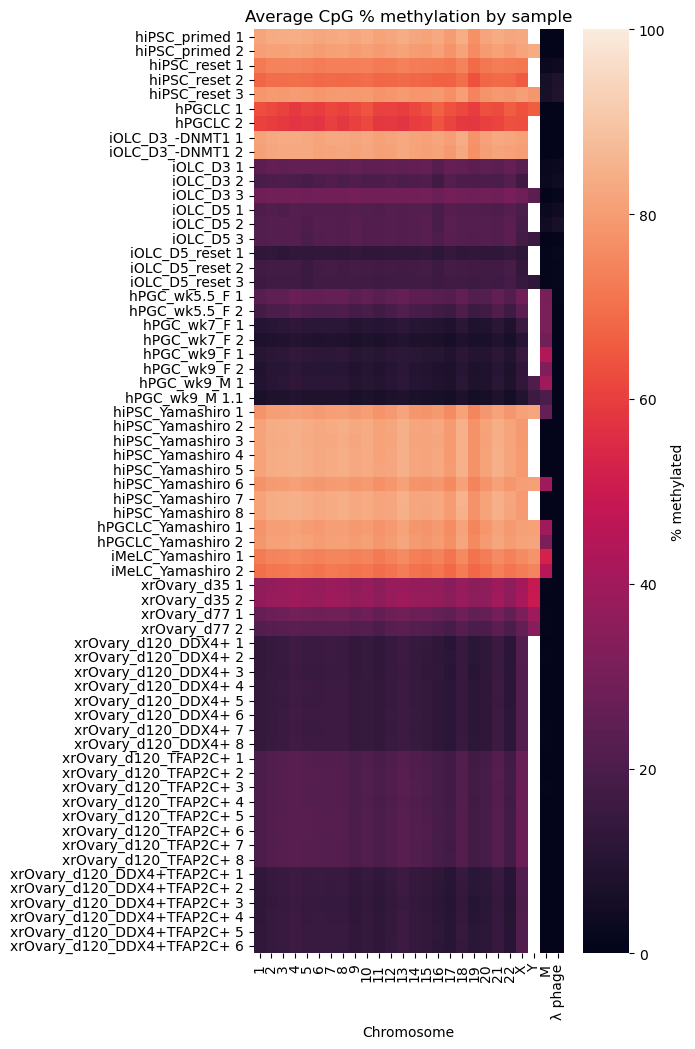

In [33]:
fig, ax = plt.subplots(figsize=(5,12))
sns.heatmap(chroms_to_plot2.T, vmin = 0, vmax = 100, xticklabels=True, yticklabels=True, cbar_kws={'label': '% methylated'}, ax=ax)
plt.title("Average CpG % methylation by sample")
plt.xlabel("Chromosome")
plt.savefig("output/chromosomes/2024-01-18_chromosome_methylation_T.png", dpi=256, bbox_inches = "tight")
plt.savefig("output/chromosomes/2024-01-18_chromosome_methylation_T_0.svg", bbox_inches = "tight")